<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepPoseKit Step 3 - Train a model

This is step 3 of the example notebooks for using DeepPoseKit. This notebook shows you how to use your annotated data to train a deep learning model applying data augmentation and using callbacks for logging the training process and saving the best model during training.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu

If you haven't already installed DeepPoseKit you can run the next cell

In [1]:
import sys
!{sys.executable} -m pip install -U deepposekit

Requirement already up-to-date: deepposekit in /usr/local/lib/python3.6/dist-packages (0.3.9)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [6]:
tf.test.is_gpu_available()

True

In [7]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [8]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5965584919905991761
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13588164997400710833
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5952955965571820921
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16083467807700665199
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [9]:
tf.test.gpu_device_name()


'/device:GPU:0'

In [10]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18224454667148490167
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15134453838935381421
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15702372903413508026
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14912199066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6483703867836322027
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [11]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia

from deepposekit.models import (StackedDenseNet,
                                DeepLabCut,
                                StackedHourglass,
                                LEAP)
from deepposekit.models import load_model

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from deepposekit.callbacks import Logger, ModelCheckpoint


import time
from os.path import expanduser
import os
try:
    import google.colab
    IN_COLAB = True
    HOME = '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom'
    video_file_path = '/human/'
    video_file_name = 'pose_human_test.mp4'
        
except:
    IN_COLAB = False
    HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
    video_file_path = '\\human\\'
    video_file_name = 'pose_human_test.mp4'

#HOME = expanduser("~") if not IN_COLAB else '.'

In [12]:
# HOME = 'E:\\Work\\github repos\\deepposekit_data_custom'
# video_file_path = '\\human\\'
# video_file_name = 'pose_human_test.mp4'

In [13]:
### Resize video and annotations

In [14]:
os.path.join(HOME + video_file_path, 'example_annotation_set.h5')

'/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/example_annotation_set.h5'

In [16]:
resize_shape = (640, 320)

In [17]:
import h5py
import cv2
imgs = []
with h5py.File(os.path.join(HOME + video_file_path, 'example_annotation_set.h5'), mode="r+") as h5file:
    for i, img in enumerate(h5file['images']):
        og_shape = img.shape
        print(img.shape)

        img = cv2.resize(img, resize_shape)
        print(img.shape)
        break

(320, 640, 1)
(320, 640)


In [ ]:
og_shape, resize_shape

In [ ]:
import h5py
import cv2
imgs = []
with h5py.File(os.path.join(HOME + video_file_path, 'example_annotation_set.h5'), mode="r+") as h5file:
    for i, img in enumerate(h5file['images']):
        img = cv2.resize(img, resize_shape)
        #print(img.shape)
        img = np.expand_dims(img, axis=2)
        imgs.append(img)
        #h5file['images'][i] = img
    imgs = np.stack(imgs)
        


with h5py.File(os.path.join(HOME + video_file_path, 'example_annotation_set.h5'), mode="r+") as h5file:
    del h5file['images'] 
    h5file.create_dataset("images", data=imgs)


list_annots = []
with h5py.File(os.path.join(HOME + video_file_path, 'example_annotation_set.h5'), mode="r+") as h5file:
    print(h5file['annotations'].shape)
    print(type(h5file['annotations']))
    for i, keypoints in enumerate(h5file['annotations']):

        keypoints[:,1] = keypoints[:,1] * 320 / 720
        keypoints[:,0] = keypoints[:,0] * 640 / 1280
        list_annots.append(keypoints)
        
    list_annots = np.stack(list_annots)
    print(list_annots.shape)


with h5py.File(os.path.join(HOME + video_file_path, 'example_annotation_set.h5'), mode="r+") as h5file:
    del h5file['annotations'] 
    h5file.create_dataset("annotations", data=list_annots)

Use the next cell to download the example data into your home directory

In [ ]:
#!git clone https://github.com/jgraving/deepposekit-data {HOME + '/deepposekit-data'}

There are a few example datasets to choose from:

In [18]:
HOME + video_file_path

'/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/'

In [19]:
glob.glob(HOME + video_file_path + '*annotation*.h5')

['/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/example_annotation_set.h5']

# Create a `DataGenerator`
This creates a `DataGenerator` for loading annotated data. You can also look at the doc string for more explanation:


In [20]:
DataGenerator?

In [21]:
data_generator = DataGenerator(HOME + video_file_path + 'example_annotation_set.h5')

/usr/local/lib/python3.6/dist-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

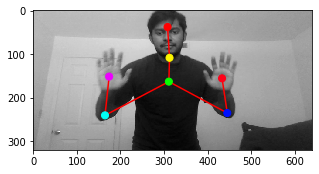

In [22]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create an augmentation pipeline
DeepPoseKit works with augmenters from the [imgaug package](https://github.com/aleju/imgaug).
This is a short example using spatial augmentations with axis flipping and affine transforms
See https://github.com/aleju/imgaug for more documentation on augmenters.

`deepposekit.augment.FlipAxis` takes the `DataGenerator` as an argument to get the keypoint swapping information defined in the annotation set. When the images are mirrored keypoints for left and right sides are swapped to avoid "confusing" the model during training.

In [23]:
augmenter = []

augmenter.append(FlipAxis(data_generator, axis=0))  # flip image up-down
augmenter.append(FlipAxis(data_generator, axis=1))  # flip image left-right 

sometimes = []
sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=(-180, 180),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)


Load an image-keypoints pair, apply augmentation, visualize it. Rerun this cell to see multiple random augmentations.

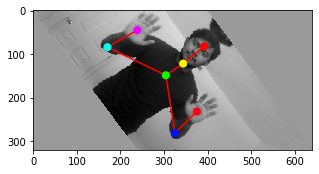

In [24]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# Create a `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [25]:
TrainingGenerator?

In [26]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=3,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=0.3, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'augmenter': True,
 'datapath': '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/example_annotation_set.h5',
 'dataset': 'images',
 'downsample_factor': 3,
 'generator': 'DataGenerator',
 'graph_scale': 1,
 'image_shape': (320, 640, 1),
 'keypoints_shape': (7, 2),
 'n_output_channels': 16,
 'n_samples': 12,
 'n_train': 9,
 'n_validation': 3,
 'output_shape': (40, 80),
 'output_sigma': 0.625,
 'random_seed': 1,
 'shuffle': True,
 'sigma': 5,
 'use_graph': True,
 'validation_split': 0.3}

# Check the `TrainingGenerator` output
This plots the training data output from the `TrainingGenerator` to ensure that the augmentation is working and the confidence maps look good. Rerun this cell to see random augmentations. 

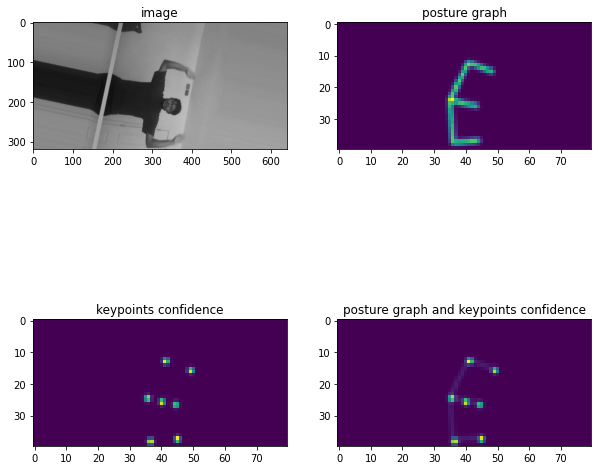

In [27]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# Define a model
Here you can define a model to train with your data. You can use our `StackedDenseNet` model, `StackedHourglass` model, `DeepLabCut` model, or the `LEAP` model. The default settings for each model should work well for most datasets, but you can customize the model architecture. The `DeepLabCut` model has multiple pretrained (on ImageNet) backbones available for using transfer learning, including the original ResNet50 (He et al. 2015)  as well as the faster MobileNetV2 (Sandler et al. 2018; see  also Mathis et al. 2019) and DenseNet121 (Huang et al. 2017). We'll select `StackedDenseNet` and set `n_stacks=2` for 2 hourglasses, with `growth_rate=32` (32 filters per convolution). Adjust the `growth_rate` and/or `n_stacks` to change model performance (and speed). You can also set `pretrained=True` to use transfer learning with `StackedDenseNet`, which uses a DenseNet121 pretrained on ImageNet to encode the images.

In [28]:
from deepposekit.models import DeepLabCut, StackedDenseNet, StackedHourglass, LEAP

You can also look at the doc strings for any of the models to get more information:

In [29]:
StackedDenseNet?

In [30]:
DeepLabCut?

In [31]:
model = StackedDenseNet(train_generator, n_stacks=2,
                        growth_rate=32, pretrained=True,
                                    n_transitions = -1)

#model = DeepLabCut(train_generator, backbone="resnet50")
#model = DeepLabCut(train_generator, backbone="mobilenetv2", alpha=0.35) # Increase alpha to improve accuracy
#model = DeepLabCut(train_generator, backbone="densenet121")

#model = LEAP(train_generator)
#model = StackedHourglass(train_generator)

model.get_config()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


{'augmenter': True,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'datapath': '/content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/example_annotation_set.h5',
 'dataset': 'images',
 'downsample_factor': 3,
 'generator': 'DataGenerator',
 'graph_scale': 1,
 'growth_rate': 32,
 'image_shape': (320, 640, 1),
 'keypoints_shape': (7, 2),
 'n_output_channels': 16,
 'n_samples': 12,
 'n_stacks': 2,
 'n_train': 9,
 'n_transitions': 6,
 'n_validation': 3,
 'name': 'StackedDenseNet',
 'output_shape': (40, 80),
 'output_sigma': 0.625,
 'pretrained': True,
 'random_seed': 1,
 'shuffle': True,
 'sigma': 5,
 'subpixel': True,
 'use_graph': True,
 'validation_split': 0.3}

# Test the prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [32]:
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")

In [33]:
x.shape

(10000, 320, 640, 1)

In [35]:

y = model.predict(x[:100], batch_size=100) # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=1, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

  524/10000 [>.............................] - ETA: 2:37

KeyboardInterrupt: ignored

# Define callbacks to enhance model training
Here you can define callbacks to pass to the model for use during training. You can use any callbacks available in `deepposekit.callbacks` or `tensorflow.keras.callbacks`

Remember, if you set `validation_split=0` for your `TrainingGenerator`, which will just use the training set for model fitting, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.


`Logger` evaluates the validation set (or training set if `validation_split=0` in the `TrainingGenerator`) at the end of each epoch and saves the evaluation data to a HDF5 log file (if `filepath` is set).

In [49]:
logger = Logger(validation_batch_size=1,
    # filepath saves the logger data to a .h5 file
    # filepath=HOME + "/deepposekit-data/datasets/fly/log_densenet.h5"
)

`ReduceLROnPlateau` automatically reduces the learning rate of the optimizer when the validation loss stops improving. This helps the model to reach a better optimum at the end of training.

In [37]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, verbose=1, patience=20)

`ModelCheckpoint` automatically saves the model when the validation loss improves at the end of each epoch. This allows you to automatically save the best performing model during training, without having to evaluate the performance manually.


In [38]:
model_checkpoint = ModelCheckpoint(
    HOME + video_file_path + "best_model_densenet.h5",
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    verbose=1,
    save_best_only=True,
)

`EarlyStopping` automatically stops the training session when the validation loss stops improving for a set number of epochs, which is set with the `patience` argument. This allows you to save time when training your model if there's not more improvment.

In [39]:
early_stop = EarlyStopping(
    monitor="val_loss",
    # monitor="loss" # use if validation_split=0
    min_delta=0.001,
    patience=100,
    verbose=1
)

Create a list of callbacks to pass to the model

In [50]:
callbacks = [early_stop, reduce_lr, model_checkpoint, logger]

# Fit the model

This fits the model for a set number of epochs with small batches of data. If you have a small dataset initially you can set `batch_size` to a small value and manually set `steps_per_epoch` to some large value, e.g. 500, to increase the number of batches per epoch, otherwise this is automatically determined by the size of the dataset.

The number of `epochs` is set to `epochs=200` for demonstration purposes. **Increase the number of epochs to train the model longer, for example `epochs=1000`**. The `EarlyStopping` callback will then automatically end training if there is no improvement. See the doc string for details:

In [41]:
model.fit?

In [51]:
model.fit(
    batch_size=1,
    validation_batch_size=1,
    callbacks=callbacks,
    #epochs=1000, # Increase the number of epochs to train the model longer
    epochs=5,
    n_workers=8,
    steps_per_epoch=None,
)

Epoch 1/5
3/9 [=========>....................] - ETA: 15s - loss: 71.2685 - output_0_loss: 23.7753 - output_1_loss: 23.7279 - output_2_loss: 23.7654
Epoch 00001: val_loss improved from 73.93506 to 71.26853, saving model to /content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean: 94.17 (0%:  0.88, 5%:  0.95, 25%:  4.75, 50%: 92.88, 75%: 167.36, 95%: 188.19, 100%: 242.12) 
confidence - mean:  0.02 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.02, 95%:  0.04, 100%:  0.04) 

9/9 [==============================] - 17s 2s/step - loss: 63.7263 - output_0_loss: 21.2219 - output_1_loss: 21.2378 - output_2_loss: 21.2666 - val_loss: 71.2685 - val_output_0_loss: 23.7753 - val_output_1_loss: 23.7279 - val_output_2_loss: 23.7654
Epoch 2/5
3/9 [=========>....................] - ETA: 15s - loss: 70.0919 - output_0_loss: 23.4999 - output_1_loss: 23.1737 - output_2_loss: 23.4183
Epoch 00002: val_loss impro

# Load the model and resume training

This loads the saved model and passes it the augmentation pipeline and `DataGenerator` from earlier.

In [52]:
model = load_model(
    HOME + video_file_path + "best_model_densenet.h5",
    augmenter=augmenter,
    generator=data_generator,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


To resume training, simply call `model.fit` again. We'll run it for another 30 `epochs`

In [53]:
model.fit(
    batch_size=1,
    validation_batch_size=1,
    callbacks=callbacks,
    epochs=5,
    n_workers=8,
    steps_per_epoch=None,
)

Epoch 1/5
3/9 [=========>....................] - ETA: 21s - loss: 65.1499 - output_0_loss: 21.6734 - output_1_loss: 21.8553 - output_2_loss: 21.6212 
Epoch 00001: val_loss improved from 65.60372 to 65.14989, saving model to /content/drive/MyDrive/GitHub IU/bam/deepposekit_clone/deepposekit_data_custom/human/best_model_densenet.h5
evaluation_metrics: 
euclidean - mean: 76.78 (0%:  0.44, 5%:  2.63, 25%:  6.00, 50%: 53.50, 75%: 151.21, 95%: 185.92, 100%: 243.33) 
confidence - mean:  0.08 (0%:  0.01, 5%:  0.01, 25%:  0.02, 50%:  0.08, 75%:  0.13, 95%:  0.18, 100%:  0.26) 

9/9 [==============================] - 65s 7s/step - loss: 52.0852 - output_0_loss: 17.4723 - output_1_loss: 17.3579 - output_2_loss: 17.2549 - val_loss: 65.1499 - val_output_0_loss: 21.6734 - val_output_1_loss: 21.8553 - val_output_2_loss: 21.6212
Epoch 2/5
3/9 [=========>....................] - ETA: 15s - loss: 70.7367 - output_0_loss: 23.1913 - output_1_loss: 24.2518 - output_2_loss: 23.2936 
Epoch 00002: val_loss did